Custom Naive Bayes Accuracy: 0.8589
Custom Naive Bayes F1 Score: 0.8584


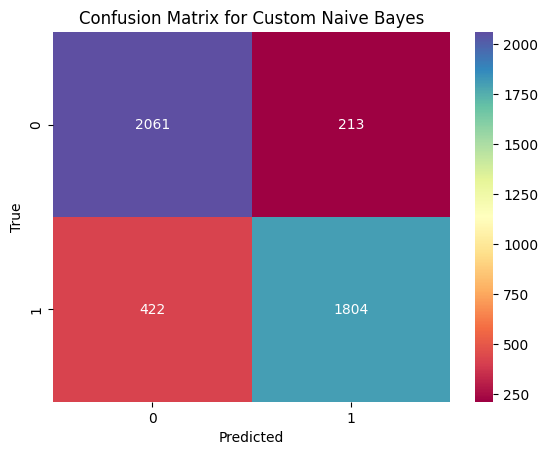

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/content/small_books_rating.csv')

data = data[(data['review/score'] <= 2) | (data['review/score'] >= 4)]
data['label'] = np.where(data['review/score'] >= 4, 1, 0)

X = data['review/text'].values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

class CustomNaiveBayes:
    def __init__(self):
        self.class_log_prior = {}
        self.feature_log_prob = {}
        self.classes = []

    def fit(self, X_train, y_train):
        self.classes, class_counts = np.unique(y_train, return_counts=True)
        total_samples = len(y_train)
        self.class_log_prior = {c: np.log(class_counts[i] / total_samples) for i, c in enumerate(self.classes)}

        word_counts = np.zeros((len(self.classes), X_train.shape[1]))
        for i, label in enumerate(y_train):
            word_counts[label] += X_train[i].toarray()[0]

        smoothed_word_counts = word_counts + 1
        class_word_totals = smoothed_word_counts.sum(axis=1)
        self.feature_log_prob = np.log(smoothed_word_counts) - np.log(class_word_totals[:, None])

    def predict(self, X_test):
        class_log_probs = []
        for i in range(X_test.shape[0]):
            log_probs = []
            for idx, c in enumerate(self.classes):
                log_prob = self.class_log_prior[c] + (X_test[i].toarray()[0] @ self.feature_log_prob[idx])
                log_probs.append(log_prob)
            class_log_probs.append(self.classes[np.argmax(log_probs)])
        return class_log_probs

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.mean(y_pred == y_test), y_pred

custom_nb = CustomNaiveBayes()
custom_nb.fit(X_train_vectorized, y_train)

# Evaluation
custom_accuracy, custom_predictions = custom_nb.score(X_test_vectorized, y_test)
custom_f1 = f1_score(y_test, custom_predictions, average='macro')
print(f"Custom Naive Bayes Accuracy: {custom_accuracy:.4f}")
print(f"Custom Naive Bayes F1 Score: {custom_f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, custom_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Spectral')
plt.title('Confusion Matrix for Custom Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
